In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)

In [2]:
! ls ../data/2_spanish_translation/

test_table.csv	user_table.csv


In [3]:
user = pd.read_csv("../data/2_spanish_translation/user_table.csv")
test = pd.read_csv("../data/2_spanish_translation/test_table.csv")
  
print(user.shape, test.shape)

(452867, 4) (453321, 9)


In [4]:
test.user_id.nunique()

453321

In [5]:
print(test['user_id'].nunique()==len(test['user_id']))
print(user['user_id'].nunique()==len(user['user_id']))

True
True


In [6]:
print(len(user['user_id']) - len(test['user_id']))

-454


In [7]:
# join
data = test.merge(user, on=['user_id'])
  
#make it a date
data["date"]   = pd.to_datetime(data["date"])
print(data.describe(include="all"))

               user_id                 date  source  device browser_language ads_channel      browser     conversion           test     sex            age country
count    452867.000000               452867  452867  452867           452867      181693       452867  452867.000000  452867.000000  452867  452867.000000  452867
unique             NaN                    5       3       2                3           5            7            NaN            NaN       2            NaN      17
top                NaN  2015-12-04 00:00:00     Ads     Web               ES    Facebook  Android_App            NaN            NaN       M            NaN  Mexico
freq               NaN               141024  181693  251316           377160       68358       154977            NaN            NaN  264485            NaN  128484
first              NaN  2015-11-30 00:00:00     NaN     NaN              NaN         NaN          NaN            NaN            NaN     NaN            NaN     NaN
last               NaN

In [8]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [9]:
country_conversion = data.query('test == 0').groupby('country')['conversion'].mean()
  
print(country_conversion.sort_values(ascending=False))

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64


In [10]:
#a simple t-test here should work. We have collected ~0.5MM data and test/control split is ~50/50.
from scipy import stats
  
#nothing changed in Spain, so no point in keeping those users
data = data.query('country != "Spain"') 
  
#t-test of test vs control for our target metric 
test = stats.ttest_ind(data[data['test'] == 1]['conversion'], 
                       data[data['test'] == 0]['conversion'], 
                       equal_var=False
                       )
  
print(data.groupby('test')['conversion'].mean())

test
0    0.048292
1    0.043411
Name: conversion, dtype: float64


In [11]:
print(test.statistic)
print(test.pvalue)

-7.353895203080277
1.9289178577799033e-13


Mmh…control users are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are:

1) We didn’t collect enough data

2) Some bias has been introduced in the experiment so that test/control people are not really random 

/home/ww6p9/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until


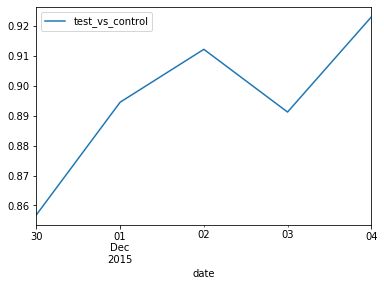

In [12]:
#compare test and control conversion rate by day and plot it
data_test_by_day = data.groupby("date")["conversion"].agg({
"test_vs_control": lambda x: x[data["test"]==1].mean()/x[data["test"]==0].mean()
}).plot()

From the plot, we notice a couple of things:

- Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up

- As a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better

In [13]:
#let's group by source and estimate relative frequencies
data_grouped_source = data.groupby("source")["test"].agg({
"frequency_test_0": lambda x: len(x[x==0]), 
"frequency_test_1": lambda x: len(x[x==1])
})
    
#get relative frequencies

/home/ww6p9/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  after removing the cwd from sys.path.


In [14]:
print(data_grouped_source/data_grouped_source.sum())

        frequency_test_0  frequency_test_1
source                                    
Ads             0.401228          0.400641
Direct          0.200949          0.199500
SEO             0.397823          0.399858


As we can see, relative frequency of source for different segments is the same. That is, we have basically the same proportion of users coming from Ads, Direct, and SEO in both test and control.

In [15]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
#make date as string, so few dates that makes sense to have them as few dummy values  
data['date'] = data['date'].apply(str)
  
#make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization
data_dummy = pd.get_dummies(data)
#model features, test is the label and conversion is not needed 
train_cols = data_dummy.drop(['test', 'conversion'], axis=1)
  
tree=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to understand the tree output
    class_weight="balanced",
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data_dummy['test'])
  
export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_test.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_test.dot")
s.view()

'tree_test.dot.pdf'

So we can see that test and control are not the same! Users from Argentina and Uruguay are way more likely to be in test than control. When country_Argentina is 1, the tree shows that users in control are ~23% and in test 77%. For Uruguay, the proportions are even more extreme: 11% in control and 89% in test! Not good! 

In [16]:
print(data_dummy.groupby("test")[["country_Argentina", "country_Uruguay"]].mean())

      country_Argentina  country_Uruguay
test                                    
0              0.050488         0.002239
1              0.173223         0.017236


Our tree was right! In test, 17% of users are from Argentina, but in control only 5% of users are from Argentina. Uruguay is even more extreme: test has 1.7% of users from Uruguay and control has just 0.2% of Uruguayan users.

And this is a big problem because that means we are not comparing anymore apples to apples in our A/B test. The difference we might see in conversion rate might very well depend on the fact that users between the two groups are different.

In [17]:
#this is the test results using the orginal dataset
original_data = stats.ttest_ind(data_dummy[data['test'] == 1]['conversion'], 
                                data_dummy[data['test'] == 0]['conversion'], 
                                equal_var=False)
  
#this is after removing Argentina and Uruguay
data_no_AR_UR = stats.ttest_ind(data_dummy[(data['test'] == 1) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                data_dummy[(data['test'] == 0) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                equal_var=False)
  
print(
pd.DataFrame({"data_type" : ["Full", "Removed_Argentina_Uruguay"], 
                  "p_value" : [original_data.pvalue, data_no_AR_UR.pvalue],
                  "t_statistic" : [original_data.statistic, data_no_AR_UR.statistic]
                 })
)

                   data_type       p_value  t_statistic
0                       Full  1.928918e-13    -7.353895
1  Removed_Argentina_Uruguay  7.200849e-01     0.358346


Huge difference! The biased test where some countries are over/under represented is statistically significant with negative t statistics. So test is worse than control! After removing those two countries, we get non-significant results. 

In [18]:
data_test_country = data.groupby('country')['conversion'].agg({
                   "p_value": lambda x: stats.ttest_ind(x[data["test"]==1], 
                                                        x[data["test"]==0], 
                                                        equal_var=False
                                                        ).pvalue,
                   "conversion_test": lambda x: x[data["test"]==1].mean(),
                   "conversion_control": lambda x: x[data["test"]==0].mean()
                   }).reindex(['p_value','conversion_test','conversion_control'], 
                                   axis=1
                                 )
                     

/home/ww6p9/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  import sys


In [19]:
print(data_test_country.sort_values(by=['p_value']))

              p_value  conversion_test  conversion_control
country                                                   
Mexico       0.165544         0.051186            0.049495
El Salvador  0.248127         0.047947            0.053554
Chile        0.302848         0.051295            0.048107
Argentina    0.335147         0.013725            0.015071
Colombia     0.423719         0.050571            0.052089
Honduras     0.471463         0.047540            0.050906
Guatemala    0.572107         0.048647            0.050643
Venezuela    0.573702         0.048978            0.050344
Costa Rica   0.687876         0.054738            0.052256
Panama       0.705327         0.049370            0.046796
Bolivia      0.718885         0.047901            0.049369
Peru         0.771953         0.050604            0.049914
Nicaragua    0.780400         0.054177            0.052647
Uruguay      0.879764         0.012907            0.012048
Paraguay     0.883697         0.049229            0.0484

At this point, you have two options:

- Acknowledge that there was a bug, go talk to the software engineer in charge of randomization, figure out what went wrong, fix it and re-run the test. Note that when you find a bug, it might be a sign that more things are messed up, not just the one you found. So when you find a bug, always try to get to the bottom of it

- If you do find out that everything else was fine, but for some reason there was only a problem with those two countries, you can potentially adjust the weights for those two segments so that relative frequencies become the same and then re-check the test results
